In [7]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from dateutil.relativedelta import relativedelta, TH
from datetime import timedelta
import time

In [8]:
data = pd.read_csv(r'C:\Users\ganes\Downloads\Entirety-Codes-main\01-07--OCT-2021-WEEKLY-expiry_data__VEGE_NF_AND_BNF_Options.csv')

data['Date/Time'] = pd.to_datetime(data['Date/Time'],format='%d-%m-%Y %H:%M:%S')

In [9]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

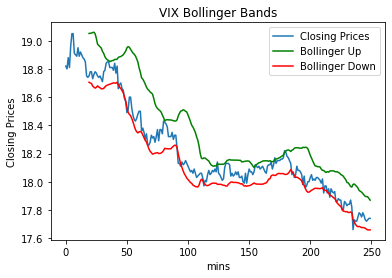

In [10]:
intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Index_Traded_Price','ATM','Days_to_Expiry','CE_Symbol','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Symbol','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])
Instrument = 'NIFTY'
base = 50
from_date = datetime.date(2021, 10, 7)
end_date = datetime.date(2021, 10, 7)
delta = datetime.timedelta(minutes=1)

cooldown = datetime.timedelta(minutes=2)

entry_datetime = datetime.datetime(2021, 10, 6, 9, 20, 0)
exit_datetime = datetime.datetime(2021, 10, 6, 15, 15, 0)

    
indexdata= data[(data['Ticker'] == 'NIFTY')]
indexdata.reset_index(drop=True,inplace=True)

vixdata = data[(data['Ticker'] == 'INDIAVIX')]
vixdata.reset_index(drop=True,inplace=True)
vixclose=vixdata['Close']

vixclosea=vixclose[:250]
vixsma = get_sma(vixclose, 20)

bollinger_up, bollinger_down = get_bollinger_bands(vixclosea)


plt.title('VIX' + ' Bollinger Bands')
plt.xlabel('mins')
plt.ylabel('Closing Prices')
plt.plot(vixclosea, label='Closing Prices')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()

strdl_entry=entry_datetime

In [11]:
def loop():
    global atm, entrydate, nearest_expiry, atmce_data, atmpe_data, atmce_symbol, atmpe_symbol, index_entry_price, atmce_entry_price, atmpe_entry_price
    
    atm = indexdata[indexdata['Date/Time'] == strdl_entry]['Open'].iloc[0]
    atm = base*round(atm/base)

    entrydate=indexdata[indexdata['Date/Time'] == strdl_entry]['Date/Time'].iloc[0]

    nearest_expiry = entrydate.date() + relativedelta(weekday=TH(+1))#.strftime('%d-%m-%Y')

    atmce_data=data[(data['Ticker']==Instrument+'WK'+str(atm)+'CE')]
    atmce_data.reset_index(drop=True,inplace=True)

    atmpe_data=data[(data['Ticker']==Instrument+'WK'+str(atm)+'PE')]
    atmpe_data.reset_index(drop=True,inplace=True)


    atmce_symbol = atmce_data['Ticker'].iloc[0]
    atmpe_symbol = atmpe_data['Ticker'].iloc[0]

    index_entry_price = indexdata[indexdata['Date/Time']==strdl_entry]['Close'].iloc[0]

    atmce_entry_price = atmce_data[atmce_data['Date/Time']==strdl_entry]['Close'].iloc[0]
    atmpe_entry_price = atmpe_data[atmpe_data['Date/Time']==strdl_entry]['Close'].iloc[0]
loop()
print(entrydate)
#print(atmce_data['Date/Time']!=entry_datetime)

2021-10-06 09:20:00


In [12]:
#start = time.time()
#atmce_ltp=0
#atmpe_ltp=0
while entry_datetime <= exit_datetime:
    current_datetime = entry_datetime
    
    entry_datetime += delta

    if strdl_entry > current_datetime:
        continue
    
    #print(atmce_data['Date/Time']==current_datetime)
    if current_datetime in atmce_data['Date/Time']:    
        atmce_data['Date/Time'][current_datetime] = atmce_data['Date/Time'][current_datetime - delta]
    if current_datetime in atmpe_data['Date/Time']:    
        atmpe_data['Date/Time'][current_datetime] = atmpe_data['Date/Time'][current_datetime - delta]
        
    atmce_ltp = atmce_data[atmce_data['Date/Time']==current_datetime]['Close'].iloc[0]
    atmpe_ltp = atmpe_data[atmpe_data['Date/Time']==current_datetime]['Close'].iloc[0]
    
    index_ltp = indexdata[indexdata['Date/Time']==current_datetime]['Close'].iloc[0]
    
    ce_pnl = atmce_entry_price - atmce_ltp
    pe_pnl = atmpe_entry_price - atmpe_ltp
    
    pnl = (ce_pnl + pe_pnl)*75
    
    if pnl >= 1000 or pnl <= -1000 :
        print(pnl)
        strdl_exit = current_datetime    
        intraday_trade_log=intraday_trade_log.append({'Entry_Datetime':strdl_entry,
                                    'Index_Traded_Price':index_entry_price,
                                    'ATM':atm,
                                    'Days_to_Expiry':(nearest_expiry - entry_datetime.date()).days,
                                    'CE_Symbol':atmce_symbol,
                                    'CE_Entry_Price':atmce_entry_price,
                                    'CE_Exit_Price':atmce_ltp,
                                    'CE_Exit_Datetime':strdl_exit,
                                    'PE_Symbol':atmpe_symbol,
                                    'PE_Entry_Price':atmpe_entry_price,
                                    'PE_Exit_Price':atmpe_ltp,
                                    'PE_Exit_Datetime':strdl_exit,
                                    'PnL':pnl},ignore_index=True)     
        print("Call Symbol :",atmce_symbol,"Call Entry :",atmce_entry_price,"Put Symbol :",atmpe_symbol, "Put Entry:", atmpe_entry_price)
        print("Call Exit:", atmce_ltp, "Put Exit:", atmpe_ltp)
        print("Straddle entry:", strdl_entry, "Straddle exit:", strdl_exit)
        #print(intraday_trade_log)
        strdl_entry = current_datetime + cooldown
        
        loop()

    elif index_ltp == atm+50 or index_ltp == atm-50:
        print(pnl)
        strdl_exit = current_datetime    
        intraday_trade_log=intraday_trade_log.append({'Entry_Datetime':strdl_entry,
                                    'Index_Traded_Price':index_entry_price,
                                    'ATM':atm,
                                    'Days_to_Expiry':(nearest_expiry - entry_datetime.date()).days,
                                    'CE_Symbol':atmce_symbol,
                                    'CE_Entry_Price':atmce_entry_price,
                                    'CE_Exit_Price':atmce_ltp,
                                    'CE_Exit_Datetime':strdl_exit,
                                    'PE_Symbol':atmpe_symbol,
                                    'PE_Entry_Price':atmpe_entry_price,
                                    'PE_Exit_Price':atmpe_ltp,
                                    'PE_Exit_Datetime':strdl_exit,
                                    'PnL':pnl},ignore_index=True)     
        print("Call Symbol :",atmce_symbol,"Call Entry :",atmce_entry_price,"Put Symbol :",atmpe_symbol, "Put Entry:", atmpe_entry_price)
        print("Call Exit:", atmce_ltp, "Put Exit:", atmpe_ltp)
        print("Straddle entry:", strdl_entry, "Straddle exit:", strdl_exit)
        strdl_entry = current_datetime + cooldown
        
        loop()

    elif current_datetime == exit_datetime:
        strdl_exit = current_datetime    
        intraday_trade_log=intraday_trade_log.append({'Entry_Datetime':strdl_entry,
                                    'Index_Traded_Price':index_entry_price,
                                    'ATM':atm,
                                    'Days_to_Expiry':(nearest_expiry - entry_datetime.date()).days,
                                    'CE_Symbol':atmce_symbol,
                                    'CE_Entry_Price':atmce_entry_price,
                                    'CE_Exit_Price':atmce_ltp,
                                    'CE_Exit_Datetime':strdl_exit,
                                    'PE_Symbol':atmpe_symbol,
                                    'PE_Entry_Price':atmpe_entry_price,
                                    'PE_Exit_Price':atmpe_ltp,
                                    'PE_Exit_Datetime':strdl_exit,
                                    'PnL':pnl},ignore_index=True)
        print("Call Symbol :",atmce_symbol,"Call Entry :",atmce_entry_price,"Put Symbol :",atmpe_symbol, "Put Entry:", atmpe_entry_price)
        print("Call Exit:", atmce_ltp, "Put Exit:", atmpe_ltp)
        print("Straddle entry:", strdl_entry, "Straddle exit:", strdl_exit)
    

intraday_trade_log
#end = time.time()
#print("The time of execution of above program is :", end-start)

-446.2500000000002
Call Symbol : NIFTYWK17850CE Call Entry : 67.3 Put Symbol : NIFTYWK17850PE Put Entry: 69.9
Call Exit: 44.25 Put Exit: 98.9
Straddle entry: 2021-10-06 09:20:00 Straddle exit: 2021-10-06 10:21:00
1001.2500000000001
Call Symbol : NIFTYWK17800CE Call Entry : 66.95 Put Symbol : NIFTYWK17800PE Put Entry: 71.6
Call Exit: 67.35 Put Exit: 57.85
Straddle entry: 2021-10-06 10:23:00 Straddle exit: 2021-10-06 12:51:00


IndexError: single positional indexer is out-of-bounds